<a href="https://colab.research.google.com/github/Narusi/My-Projects/blob/master/RevolutPortfolioNewAssets%20v1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install yfinance

In [0]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import pearsonr, spearmanr

import requests
from bs4 import BeautifulSoup

import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3)

In [36]:
def momentumBuy(close, asset='Asset', step=50, output='current', chart=False, printOut=False):
    shortBuy = close > close.rolling(step).mean()
    mediumBuy = close > close.rolling(step * 2).mean()
    longBuy = close > close.rolling(step * 4).mean()

    medMBuy = close.rolling(step).mean() > close.rolling(step * 2).mean()
    longMBuy = close.rolling(step).mean() > close.rolling(step * 4).mean()

    veryLongBuy = close.rolling(step * 2).mean() > close.rolling(200).mean()

    buySignals = pd.DataFrame(index=close.index)

    buySignals['BuySS'] = shortBuy
    buySignals['BuySM'] = mediumBuy
    buySignals['BuySL'] = longBuy
    buySignals['BuyMM'] = medMBuy
    buySignals['BuyML'] = longMBuy
    buySignals['BuyLL'] = veryLongBuy

    ts = pd.DataFrame({asset:close.div(close.iloc[0]),
                    'Returns':np.log(close/close.shift(1)),
                    'BuySignal':buySignals.sum(axis=1)},
                    index=close.index)

    momSum = ts.groupby('BuySignal')['Returns'].sum()
    momMed = ts.groupby('BuySignal')['Returns'].median()
    buySigns = []
    holdSignal = []
    sellSign = []
    losingSignals = momSum[momSum <= 0.0].index

    for bl in range(len(buySignals.columns),0,-1):        
        if np.logical_and(momSum[bl] > 0.0, bl > max(losingSignals)):
            buySigns.append(bl)
        elif momSum[bl] > 0.0:
            holdSignal.append(bl)
        elif momMed[bl] <= 0.0:
            sellSign.append(bl)

    ts['Signal'] = ''
    ts.loc[ts[ts['BuySignal'] == 0].index, 'Signal'] = 'SELL'
    
    if len(buySigns) > 1:
        for buy in buySigns:
            ts.loc[ts[ts['BuySignal'] == buy].index, 'Signal'] = 'BUY'
    elif len(buySigns) == 1:
        ts.loc[ts[ts['BuySignal'] == buySigns[0]].index, 'Signal'] = 'BUY'
        
    if len(holdSignal) > 1:
        for hold in holdSignal:
            ts.loc[ts[ts['BuySignal'] == hold].index, 'Signal'] = 'HOLD'
    elif len(holdSignal) == 1:
        ts.loc[ts[ts['BuySignal'] == holdSignal[0]].index, 'Signal'] = 'HOLD'

    if len(sellSign) > 1:
        for sell in sellSign:
            ts.loc[ts[ts['BuySignal'] == sell].index, 'Signal'] = 'SELL'
    elif len(sellSign) == 1:
        ts.loc[ts[ts['BuySignal'] == sellSign[0]].index, 'Signal'] = 'SELL'

    for b in buySignals.columns:    
        rets = ts['Returns'][buySignals[b]]
        prob = rets[rets > 0.0].count()/rets.count()    
        if printOut: print(b, prob, rets.mean());

        ts[b] = 0
        ts.loc[buySignals[buySignals[b]].index, b] = 1

    if chart:
        ts['2018':][[asset,'BuySignal']].plot(figsize=(16,8))
        plt.show();

    if printOut: print(ts.groupby('BuySignal')['Returns'].mean());
    
    for i in range(6):
        minpick = ts.loc[ts[ts['BuySignal'] >= i].index]
        probs = minpick.groupby('BuySignal')['Returns'].count()/minpick['Returns'].count()    
        rets = minpick.groupby('BuySignal')['Returns'].mean()
        std = minpick.groupby('BuySignal')['Returns'].std()

        dprobs = minpick[minpick['Returns'] < 0.0].groupby('BuySignal')['Returns'].count()/minpick.groupby('BuySignal')['Returns'].count()
        #print((probs * rets).sum())
        #print(dprobs)
    
    ts['LAG.14'] = ts['Returns'].shift(14).rolling(14).sum()
    ts['LAG.28'] = ts['Returns'].shift(28).rolling(28).sum()
    ts['LAG.60'] = ts['Returns'].shift(60).rolling(60).sum()
    ts['LAG.90'] = ts['Returns'].shift(90).rolling(90).sum()
    lags = ['LAG.14','LAG.28','LAG.60','LAG.90']
    
    signalProbs = pd.DataFrame(index=list(range(len(list(itertools.product([1, 0], 
                                                                           repeat = len(buySignals.columns)))))),
                               columns=list(buySignals.columns) + lags)
    signalProbs[buySignals.columns] = 0
    signalProbs[lags] = 0.0

    signalReturns = pd.DataFrame(index=list(range(len(list(itertools.product([1, 0], 
                                                                           repeat = len(buySignals.columns)))))),
                               columns=list(buySignals.columns) + lags)
    signalReturns[buySignals.columns] = 0
    signalReturns[lags] = 0.0

    i = 0
    for comb in itertools.product([1, 0], repeat = len(buySignals.columns)):
        comb = list(comb)
        signalProbs.loc[i, buySignals.columns] = comb

        signInd = buySignals[buySignals == comb].dropna().index
        signRets = ts[lags].reindex(signInd)
        theProbs = signRets[signRets > 0.07/step].count()/signRets.count()
        #print(comb)
        #print(buySignals[buySignals == comb].dropna().tail())
        #print(theProbs)
        signalProbs.loc[i, lags] = theProbs
        signalReturns.loc[i, lags] = signRets.median()
        i += 1
    
    for ss in buySignals.columns:
        rets = ts[ts[ss] == 1][lags].dropna()
        prob = rets[rets > 0.01].count()/rets.count()
        hrets = rets[rets > 0.01].mean()

        if printOut:
            print('\n',ss)
            print(rets.mean(), '\n',rets.median())
            print('\nProbabilities:')
            print(prob.mean())
            print((prob * hrets).mean())
    
    if printOut: print(ts.groupby('Signal')['Returns'].mean());
    
    if output == 'current' or output == 'single':
        currentState = (np.array(signalProbs[buySignals.columns].values) == np.array(ts[buySignals.columns].iloc[-1].values)).sum(axis=1) == len(buySignals.columns)
        lagOutput = []
        for lagProb in lags:
            action = ''
            if signalProbs[currentState][lagProb].values[0] > 0.75: action = 'BUY'
            elif signalProbs[currentState][lagProb].values[0] > 0.50: action = 'HOLD'
            elif signalProbs[currentState][lagProb].values[0] <= 0.50: action = 'SELL'

            lagOutput.append([lagProb, action, 
                            signalProbs[currentState][lagProb].values[0], 
                            signalReturns[currentState][lagProb].values[0]])

            if printOut:
                print(lagProb, action, 
                    round(100*signalProbs[currentState][lagProb].values[0],1),
                    round(100*signalReturns[currentState][lagProb].values[0],3))                
        
        if output == 'single':
            ttemp = pd.DataFrame(lagOutput)        
            return ttemp.loc[ttemp[2].idxmin(), 1]
        else:
            return lagOutput

    elif output == 'ts':
        return ts

a = 'BABA'
pps = yf.download(a)['Adj Close']
#print(pps.tail())
timeSeries = momentumBuy(pps, asset=a, output='ts')
print('Current state {}\n\n'.format(timeSeries['BuySignal'].iloc[-1]), 
      timeSeries.groupby(['Signal','BuySignal'])['Returns'].mean())

print(pd.DataFrame(momentumBuy(pps, asset=a, output='current'),
                   columns=list(['LAG','Signal','Profit Prob.','Return'])))

momentumBuy(pps, asset=a, output='single')

[*********************100%***********************]  1 of 1 completed
Current state 6

 Signal  BuySignal
        4           -0.001974
BUY     5            0.002428
        6            0.003443
SELL    0           -0.001219
        1           -0.000397
        2           -0.001300
        3           -0.001956
Name: Returns, dtype: float64
      LAG Signal  Profit Prob.    Return
0  LAG.14    BUY      0.844388  0.039398
1  LAG.28    BUY      0.834184  0.073688
2  LAG.60    BUY      0.770408  0.107933
3  LAG.90   HOLD      0.645408  0.105494


'HOLD'

In [37]:
portfolio = ['T', 'PFE','FB','MSFT','AMTD','SO']
candidates = ['AAPL','ABBV','ABT','ACN','ADI','AGM','AGNC','ALB','AMTD','AMZN',
              'APD','ARR','AVAL','BABA','BAH','BEN','BLK','CAH','CATY','CBT',
              'CCBG','CCL','CHD','CHRW','CFG','CL','CMA','CNI','CMCSA','COST',
              'CSCO','CVS','CVX','D','DDS','DUK','DX','EBF','EMR','ENB','EPD',
              'EPR','ES','FAST','FB','FDX','FITB','FRT','FLIC','FLO','GIS','GGG',
              'GOOG','GS','GWB','HBAN','IBCP','IBM','IMBBY','INTC','IRM','JNJ',
              'JPM','K','KEY','KMB','KO','LMT','LOW','MA','MAIN','MBWM','MCY','MCD',
              'MDP','MDT','MED','MNRL','MMM','MMP','MO','MPLX','MSFT','MSI','MSM','NHI','NFLX',
              'NNN','NKE','NJR','NRIM','NRZ','NTAP','O','OC','OKE','OZK','PEBO','PEP',
              'PFG','PG','PII','PLD','PM','PNC','PRU','RCL','RGLD','RNR','RF',
              'SBUX','SKT','SNV','SO','SPG','STAG','SWM','TGT','TM',
              'TSLA','TWO','TXN','UHT','UNH','UNM','UVV','V','VGR','VZ','WBA','WBS','WELL',
              'WEN','WFC','WM','WLK','WMT','XOM','YORW']

assets = pd.Series(portfolio + candidates).drop_duplicates().to_list()
print('\nCheck for duplicates!')
np.sort(candidates)


Check for duplicates!


array(['AAPL', 'ABBV', 'ABT', 'ACN', 'ADI', 'AGM', 'AGNC', 'ALB', 'AMTD',
       'AMZN', 'APD', 'ARR', 'AVAL', 'BABA', 'BAH', 'BEN', 'BLK', 'CAH',
       'CATY', 'CBT', 'CCBG', 'CCL', 'CFG', 'CHD', 'CHRW', 'CL', 'CMA',
       'CMCSA', 'CNI', 'COST', 'CSCO', 'CVS', 'CVX', 'D', 'DDS', 'DUK',
       'DX', 'EBF', 'EMR', 'ENB', 'EPD', 'EPR', 'ES', 'FAST', 'FB', 'FDX',
       'FITB', 'FLIC', 'FLO', 'FRT', 'GGG', 'GIS', 'GOOG', 'GS', 'GWB',
       'HBAN', 'IBCP', 'IBM', 'IMBBY', 'INTC', 'IRM', 'JNJ', 'JPM', 'K',
       'KEY', 'KMB', 'KO', 'LMT', 'LOW', 'MA', 'MAIN', 'MBWM', 'MCD',
       'MCY', 'MDP', 'MDT', 'MED', 'MMM', 'MMP', 'MNRL', 'MO', 'MPLX',
       'MSFT', 'MSI', 'MSM', 'NFLX', 'NHI', 'NJR', 'NKE', 'NNN', 'NRIM',
       'NRZ', 'NTAP', 'O', 'OC', 'OKE', 'OZK', 'PEBO', 'PEP', 'PFG', 'PG',
       'PII', 'PLD', 'PM', 'PNC', 'PRU', 'RCL', 'RF', 'RGLD', 'RNR',
       'SBUX', 'SKT', 'SNV', 'SO', 'SPG', 'STAG', 'SWM', 'TGT', 'TM',
       'TSLA', 'TWO', 'TXN', 'UHT', 'UNH', 'UNM', 'UVV', 'V',

In [38]:
data = yf.download(assets, period='10y').sort_index().resample('D').last()

prices = data['Adj Close'].fillna(method="ffill")
close = data['Close'].fillna(method="ffill")

(prices.count()[prices.count() < prices.count().quantile(0.05)]/365).sort_values()

[*********************100%***********************]  141 of 141 completed


MNRL    0.723288
CFG     5.290411
AVAL    5.293151
BABA    5.304110
NRZ     6.687671
ABBV    7.016438
MPLX    7.202740
dtype: float64

In [39]:
for a in prices.count()[prices.isna().sum() > 3*365].index:
    if a not in portfolio:
        prices = prices.drop(a, axis=1)
        print('Droping ' + a + ' for lack of historical prices.')

Droping AVAL for lack of historical prices.
Droping BABA for lack of historical prices.
Droping CFG for lack of historical prices.
Droping MNRL for lack of historical prices.
Droping NRZ for lack of historical prices.


In [40]:
def extractDetails(df1, df2, cols):
    try:
        df = df2[(df2[cols] == df1[cols]).sum(axis=1) == len(cols)].index
    except:
        print(df2[cols], df1[cols], cols)
    return df

def momentum(close, asset='Asset', step=50, output='current', chart=False, printOut=False):
    shortBuy = close > close.rolling(step).mean()
    mediumBuy = close > close.rolling(step * 2).mean()
    longBuy = close > close.rolling(step * 4).mean()

    medMBuy = close.rolling(step).mean() > close.rolling(step * 2).mean()
    longMBuy = close.rolling(step).mean() > close.rolling(step * 4).mean()
    veryLongBuy = close.rolling(step * 2).mean() > close.rolling(step * 4).mean()

    buySignals = pd.DataFrame(index=close.index)

    buySignals['BuySS'] = shortBuy
    buySignals['BuySM'] = mediumBuy
    buySignals['BuySL'] = longBuy
    buySignals['BuyMM'] = medMBuy
    buySignals['BuyML'] = longMBuy
    buySignals['BuyLL'] = veryLongBuy

    buySignals['BuySSc'] = 0
    buySignals['BuySMc'] = 0
    buySignals['BuySLc'] = 0
    buySignals['BuyMMc'] = 0
    buySignals['BuyMLc'] = 0
    buySignals['BuyLLc'] = 0

    buySignals['BuySSp'] = 0.0
    buySignals['BuySMp'] = 0.0
    buySignals['BuySLp'] = 0.0
    buySignals['BuyMMp'] = 0.0
    buySignals['BuyMLp'] = 0.0
    buySignals['BuyLLp'] = 0.0

    fwdRets = pd.Series(np.log(close/close.shift(1))).fillna(0.0)
    buySignals['RetS'] = fwdRets.rolling(int(step/2)).sum().shift(int(step/2))
    buySignals['RetM'] = fwdRets.rolling(step).sum().shift(step)
    buySignals['RetL'] = fwdRets.rolling(step * 4).sum().shift(step * 4)

    signalCols = ['BuySS','BuySM','BuySL','BuyMM','BuyML','BuyLL']
    signCountCols = ['BuySSc','BuySMc','BuySLc','BuyMMc','BuyMLc','BuyLLc']
    probCols = ['BuySSp','BuySMp','BuySLp','BuyMMp','BuyMLp','BuyLLp']
    retsCol = ['RetS','RetM','RetL']
    sCols = signalCols + signCountCols
    allCols = sCols + probCols

    for cCol in signCountCols:
        buySignals[cCol] = pd.to_numeric(buySignals[cCol])

    for i in buySignals.index:
        for a in signalCols:
            if buySignals.loc[i, a]: 
                buySignals.loc[i, str(a) + 'c'] = buySignals.shift(1).loc[i, str(a) + 'c'] + 1
            else: 
                buySignals.loc[i, str(a) + 'c'] = 0
            
            bsInd = buySignals[buySignals[a] == buySignals.loc[i, a]].index
            rets = buySignals.loc[bsInd].loc[:i, 'RetM']
            buySignals.loc[i, str(a) + 'p'] = rets[rets >= 0.001].count()/rets.count()
    
    for cCol in signCountCols:
        buySignals[cCol][np.logical_and(buySignals[cCol] > 0, buySignals[cCol] <= 7)] = 1
        buySignals[cCol][np.logical_and(buySignals[cCol] > 7, buySignals[cCol] <= 14)] = 2
        buySignals[cCol][np.logical_and(buySignals[cCol] > 14, buySignals[cCol] <= 28)] = 3
        buySignals[cCol][np.logical_and(buySignals[cCol] > 28, buySignals[cCol] <= 90)] = 4
        buySignals[cCol][buySignals[cCol] > 28] = 5
    
    summary = buySignals.groupby(sCols)[retsCol].mean()

    if output == 'current':
        return buySignals.iloc[-1]
    elif output == 'short':
        return buySignals.tail(step)
    elif output == 'full':
        return buySignals
    elif output == 'expRet':
        return summary.loc[buySignals.loc[tuple(sCols)].iloc[-1]]

for a in portfolio:
    print(a)
    print(momentum(prices[a], asset=a, step=30, output='current'))

T


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

BuySS          True
BuySM          True
BuySL          True
BuyMM          True
BuyML          True
BuyLL          True
BuySSc            3
BuySMc            3
BuySLc            5
BuyMMc            1
BuyMLc            5
BuyLLc            5
BuySSp     0.554015
BuySMp     0.639367
BuySLp     0.692135
BuyMMp      0.72307
BuyMLp     0.763314
BuyLLp     0.734657
RetS      0.0245649
RetM     -0.0314377
RetL       0.183788
Name: 2020-01-06 00:00:00, dtype: object
PFE
BuySS          True
BuySM          True
BuySL          True
BuyMM          True
BuyML          True
BuyLL          True
BuySSc            4
BuySMc            4
BuySLc            4
BuyMMc            4
BuyMLc            4
BuyLLc            4
BuySSp     0.601376
BuySMp     0.662607
BuySLp     0.706495
BuyMMp     0.737934
BuyMLp     0.749788
BuyLLp      0.73887
RetS       0.024253
RetM      0.0367063
RetL      -0.100095
Name: 2020-01-06 00:00:00, dtype: object
FB
BuySS           True
BuySM           True
BuySL           True
BuyMM   

In [41]:
for a in portfolio:
    print(a)
    print(pd.DataFrame(momentumBuy(prices[a], a, 
                                   output='current'),
                       columns=list(['LAG','Signal','Profit Prob.','Return'])))

T
      LAG Signal  Profit Prob.    Return
0  LAG.14   HOLD      0.729478  0.014831
1  LAG.28    BUY      0.770522  0.028031
2  LAG.60    BUY      0.852612  0.052992
3  LAG.90   HOLD      0.736940  0.046629
PFE
      LAG Signal  Profit Prob.    Return
0  LAG.14   HOLD      0.698225  0.012733
1  LAG.28   HOLD      0.721893  0.029893
2  LAG.60   HOLD      0.514793  0.002623
3  LAG.90   SELL      0.189349 -0.063057
FB
      LAG Signal  Profit Prob.    Return
0  LAG.14   HOLD      0.694161  0.020390
1  LAG.28    BUY      0.829472  0.040054
2  LAG.60    BUY      0.762743  0.064604
3  LAG.90   HOLD      0.718258  0.072967
MSFT
      LAG Signal  Profit Prob.    Return
0  LAG.14   HOLD      0.727216  0.017098
1  LAG.28    BUY      0.817728  0.031800
2  LAG.60    BUY      0.835206  0.048087
3  LAG.90    BUY      0.826467  0.067114
AMTD
      LAG Signal  Profit Prob.    Return
0  LAG.14   HOLD      0.578947  0.009880
1  LAG.28    BUY      1.000000  0.064058
2  LAG.60   SELL      0.210526 -0.0531

In [63]:
mret = prices.pct_change(28).fillna(0.0)
mret['Portfolio'] = mret[portfolio].mean(axis=1)

mlogret = np.log(prices/prices.shift(1)).rolling(28).sum().fillna(0.0)
mlogret['Portfolio'] = mlogret[portfolio].mean(axis=1)

mlogret['Portfolio'].describe()

count    3653.000000
mean        0.010461
std         0.031245
min        -0.111520
25%        -0.006900
50%         0.012744
75%         0.030389
max         0.132335
Name: Portfolio, dtype: float64

In [43]:
profiles = pd.DataFrame(columns=list(['Name', 'Industry', 'Sub-Industry']), 
                        index=prices.columns, dtype=str)
profiles['Action'] = ''
profiles['Profit Prob.'] = 0.0
profiles['Beta'] = 0.0
profiles['RET'] = mret[profiles.index].mean().mul(12)
profiles['STD'] = mret[profiles.index].std().mul(np.sqrt(12))

i = 1
for a in prices.columns:
    try:
        profile_page = requests.get('https://finance.yahoo.com/quote/' + str(a) + '/profile?p=' + str(a))
        soup = BeautifulSoup(profile_page.content, 'html.parser')

        #print(a)

        profiles.loc[a, 'Name'] = soup.find('h3', {'class':"Fz(m) Mb(10px)"}).text

        for span in soup.find_all('span', {'class':'Fw(600)'}):
            if str(span).find('data-reactid="21"') > 0: 
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="22"') > 0:
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="23"') > 0:
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
        
            if str(span).find('data-reactid="25"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="26"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="27"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
        
        aact = momentumBuy(prices[a], asset=a, output='single')
        curr = momentumBuy(prices[a], asset=a, output='current')
        
        profiles.loc[a, 'Action'] = aact
        profiles.loc[a, 'Profit Prob.'] = round(100*curr[1][2],2)
        
    except:
        print(a)
        profiles = profiles.drop(a)
        prices = prices.drop(a, axis=1)

    proc = round(i/len(prices.columns),3)
    #print(i, proc, proc % 0.1)
    if proc % 0.1 >= 0.095:
        print('{}% processed.'.format(100 * proc))
    i += 1

profiles.info()

9.6% processed.
19.900000000000002% processed.
39.7% processed.
50.0% processed.
59.599999999999994% processed.
69.89999999999999% processed.
89.7% processed.
100.0% processed.
<class 'pandas.core.frame.DataFrame'>
Index: 136 entries, AAPL to YORW
Data columns (total 8 columns):
Name            136 non-null object
Industry        136 non-null object
Sub-Industry    136 non-null object
Action          136 non-null object
Profit Prob.    136 non-null float64
Beta            136 non-null float64
RET             136 non-null float64
STD             136 non-null float64
dtypes: float64(4), object(4)
memory usage: 14.6+ KB


In [0]:
profiles['Beta'] = mlogret.cov()['Portfolio']/mlogret.drop('Portfolio', axis=1).var().loc[profiles.index]

In [0]:
ret = prices.pct_change().dropna()
wret = prices.asfreq(freq='W', method='ffill').pct_change().dropna()
wretRoll = prices.pct_change(7).dropna()

log_ret = np.log(prices.div(prices.shift(1))).fillna(0.0)
alog_ret = log_ret.rolling(365).sum()

ret['Portfolio'] = ret[portfolio].mean(axis=1)
log_ret['Portfolio'] = log_ret[portfolio].mean(axis=1).fillna(0.0)

In [65]:
#Need to add Price to Earnings and Price to Book to profiles
profiles.loc[portfolio].sort_values(by=[ 'Action', 'Profit Prob.'], ascending=False)

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
AMTD,TD Ameritrade Holding Corporation,Financial Services,Capital Markets,SELL,100.00,0.267799,0.153246,0.282439,0.113135,0.294879
PFE,Pfizer Inc.,Healthcare,Drug Manufacturers—General,SELL,72.19,0.398928,0.113074,0.159694,0.110606,0.182539
FB,"Facebook, Inc.",Communication Services,Internet Content & Information,HOLD,82.95,0.194325,0.219798,0.295077,0.170014,0.312260
MSFT,Microsoft Corporation,Technology,Software—Infrastructure,HOLD,81.77,0.369278,0.192965,0.186481,0.187676,0.226950
SO,The Southern Company,Utilities,Utilities—Regulated Electric,HOLD,77.64,0.229985,0.111155,0.121735,0.111819,0.142237
T,AT&T Inc.,Communication Services,Telecom Services,HOLD,77.05,0.318449,0.097022,0.147526,0.087678,0.167678


In [47]:
profiles.loc[mlogret[mlogret['Portfolio'] < 0.0].corr()['Portfolio'].sort_values().head(15).index].sort_values(by='Profit Prob.')

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD
DUK,Duke Energy Corporation,Utilities,Utilities—Regulated Electric,SELL,12.50,0.184045,0.097938,0.131916
MMP,"Magellan Midstream Partners, L.P.",Energy,Oil & Gas Midstream,SELL,12.58,0.167456,0.172743,0.178897
NRIM,"Northrim BanCorp, Inc.",Financial Services,Banks—Regional,SELL,19.57,0.162223,0.128462,0.213403
NNN,"National Retail Properties, Inc.",Real Estate,REIT—Retail,SELL,28.85,0.142111,0.146328,0.178003
O,Realty Income Corporation,Real Estate,REIT—Retail,SELL,30.77,0.166351,0.150037,0.178626
RGLD,"Royal Gold, Inc.",Basic Materials,Gold,SELL,32.32,0.008955,0.168172,0.381750
MCD,McDonald's Corporation,Consumer Cyclical,Restaurants,SELL,42.25,0.234169,0.142337,0.126038
YORW,The York Water Company,Utilities,Utilities—Regulated Water,HOLD,72.09,0.125766,0.151117,0.185684
VGR,Vector Group Ltd.,Consumer Defensive,Tobacco,HOLD,75.20,0.154700,0.163399,0.198308
D,"Dominion Energy, Inc.",Utilities,Utilities—Diversified,HOLD,76.56,0.265861,0.115706,0.129751


In [48]:
portfolio_ind = profiles.loc[portfolio].groupby('Industry').count()['Name']
portfolio_subind = profiles.loc[portfolio].groupby('Sub-Industry').count()['Name']

print(portfolio_subind)
selection = profiles
industryCount = len(profiles.groupby('Industry').count().index)
subIndustryCount = len(profiles.groupby('Sub-Industry').count().index)

port_Ind_fully_invested = len(portfolio_ind.index) == industryCount
port_subInd_fully_invested = len(portfolio_subind.index) == subIndustryCount

for i in portfolio_ind.index:
    if port_Ind_fully_invested:
        if portfolio_ind.loc[i] == portfolio_ind.min():
            selection = selection[selection['Industry'] == i]
        else:
            selection = selection[selection['Industry'] != i]
    else:
        selection = selection[selection['Industry'] != i]
for i in portfolio_subind.index:
    if port_subInd_fully_invested:
        if portfolio_subind.loc[i] == portfolio_subind.min():
            selection = selection[selection['Industry'] == i]
        else:
            selection = selection[selection['Industry'] != i]
    else:
        selection = selection[selection['Sub-Industry'] != i]

selection = selection[selection['Action'] != 'SELL']

selection.sort_values(by=['Industry', 'Profit Prob.'])

Sub-Industry
Capital Markets                   1
Drug Manufacturers—General        1
Internet Content & Information    1
Software—Infrastructure           1
Telecom Services                  1
Utilities—Regulated Electric      1
Name: Name, dtype: int64


,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD
CBT,Cabot Corporation,Basic Materials,Specialty Chemicals,HOLD,65.66,0.209175,0.115393,0.289913
WEN,The Wendy's Company,Consumer Cyclical,Restaurants,HOLD,75.15,0.191699,0.190700,0.233288
LOW,"Lowe's Companies, Inc.",Consumer Cyclical,Home Improvement Retail,HOLD,78.70,0.228462,0.196508,0.229113
RCL,Royal Caribbean Cruises Ltd.,Consumer Cyclical,Travel Services,HOLD,80.43,0.185071,0.216219,0.320127
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,HOLD,82.77,0.060804,0.394617,0.508353
NKE,"NIKE, Inc.",Consumer Cyclical,Footwear & Accessories,HOLD,83.52,0.258272,0.215747,0.193476
KO,The Coca-Cola Company,Consumer Defensive,Beverages—Non-Alcoholic,HOLD,74.96,0.319974,0.105451,0.119756
VGR,Vector Group Ltd.,Consumer Defensive,Tobacco,HOLD,75.20,0.154700,0.163399,0.198308
PM,Philip Morris International Inc.,Consumer Defensive,Tobacco,HOLD,80.88,0.163904,0.114891,0.196154
K,Kellogg Company,Consumer Defensive,Packaged Foods,HOLD,82.13,0.183800,0.059922,0.143585


In [49]:
profiles.loc[['NKE','BAH','SO','TGT','K']]

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD
NKE,"NIKE, Inc.",Consumer Cyclical,Footwear & Accessories,HOLD,83.52,0.258272,0.215747,0.193476
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,HOLD,79.59,0.133266,0.202609,0.232890
SO,The Southern Company,Utilities,Utilities—Regulated Electric,HOLD,77.64,0.229985,0.111155,0.121735
TGT,Target Corporation,Consumer Defensive,Discount Stores,SELL,82.40,0.130770,0.137969,0.233105
K,Kellogg Company,Consumer Defensive,Packaged Foods,HOLD,82.13,0.183800,0.059922,0.143585


In [50]:
val = prices[selection.index].iloc[-1]/prices[selection.index].iloc[-365:].mean()
val = val[val < 1.0]
underVal = []

for a in val.index.to_list():
    if np.logical_and(prices[a].iloc[-3*365:].pct_change().mean() > 0.0,
                      a not in portfolio):
        underVal.append(a)

print('Currently assets under consideration:\n{}'.format(underVal))

Currently assets under consideration:
[]


In [0]:
if len(underVal) > 1:
    wretRoll[underVal].plot(subplots=True, figsize=(16,8))
    plt.show();
    wretRoll[underVal].mul(52).describe()

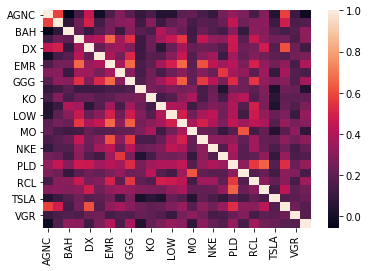

Lowest correlating assets:


,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD
AGNC,AGNC Investment Corp.,Real Estate,REIT—Mortgage,HOLD,79.71,0.146751,0.106007,0.149837
DDS,"Dillard's, Inc.",Consumer Cyclical,Department Stores,SELL,64.42,0.084152,0.209021,0.391585
FLO,"Flowers Foods, Inc.",Consumer Defensive,Packaged Foods,SELL,27.50,0.129123,0.123084,0.226148
MED,"Medifast, Inc.",Consumer Cyclical,Personal Services,SELL,26.32,0.049187,0.238998,0.423976
MPLX,MPLX LP,Energy,Oil & Gas Midstream,SELL,20.93,0.095151,0.065168,0.266432
RGLD,"Royal Gold, Inc.",Basic Materials,Gold,SELL,32.32,0.008955,0.168172,0.381750
UVV,Universal Corporation,Consumer Defensive,Tobacco,SELL,43.86,0.136208,0.090741,0.262969


In [52]:
selAss = selection.index.to_list()
low_corr = ret.corr()[ret.corr()['Portfolio'] <= ret.corr()['Portfolio'].quantile(0.05)]

sns.heatmap(mlogret.corr().loc[selAss, selAss])
plt.show();

print('Lowest correlating assets:')
profiles.loc[low_corr.index]

In [53]:
sel = selection.index.to_list()[:]
sel.append('Portfolio')

sel_corr = ret[sel].corr()['Portfolio']
print(sel_corr.sort_values().head(10))

diversifiedPicks = sel_corr.sort_values()[sel_corr<sel_corr.quantile(0.25)].index.to_list()

AGNC    0.254678
ARR     0.299421
EBF     0.306993
TSLA    0.309007
DX      0.322455
K       0.326164
VGR     0.327670
TWO     0.327921
WEN     0.342666
PM      0.358918
Name: Portfolio, dtype: float64


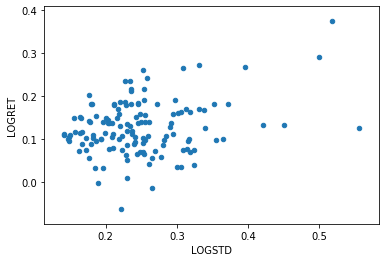

In [54]:
profiles['LOGRET'] = log_ret.mean().mul(365)
profiles['LOGSTD'] = log_ret.std().mul(np.sqrt(365))

profiles.plot(kind='scatter', x='LOGSTD', y='LOGRET')#, size='Beta')
plt.show()

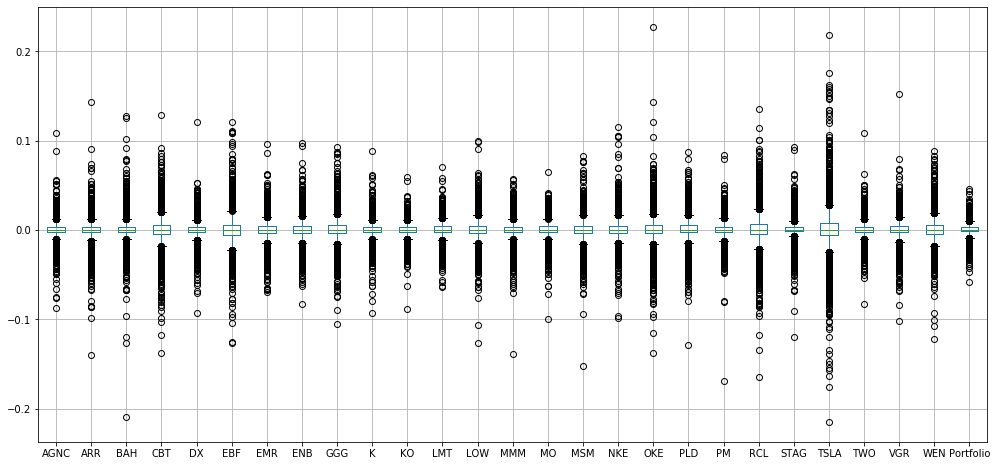

AGNC: 12.64%, 12.84%, 0.98
ARR: 10.25%, 13.06%, 0.78
BAH: 13.89%, 13.5%, 1.03
CBT: 12.23%, 14.68%, 0.83
DX: 11.14%, 13.12%, 0.85
EBF: 12.17%, 14.38%, 0.85
EMR: 12.39%, 14.05%, 0.88
ENB: 12.7%, 13.49%, 0.94
GGG: 14.25%, 14.24%, 1.0
K: 11.96%, 12.95%, 0.92
KO: 12.65%, 12.99%, 0.97
LMT: 14.04%, 13.31%, 1.06
LOW: 13.76%, 13.88%, 0.99
MMM: 12.59%, 13.7%, 0.92
MO: 13.17%, 13.11%, 1.0
MSM: 12.1%, 13.86%, 0.87
NKE: 14.18%, 13.81%, 1.03
OKE: 13.87%, 14.3%, 0.97
PLD: 13.41%, 14.08%, 0.95
PM: 12.6%, 13.23%, 0.95
RCL: 13.76%, 15.11%, 0.91
STAG: 13.28%, 13.41%, 0.99
TSLA: 15.32%, 15.53%, 0.99
TWO: 12.43%, 13.01%, 0.96
VGR: 13.43%, 13.3%, 1.01
WEN: 13.75%, 13.78%, 1.0
Portfolio: 13.02%, 13.81%, 0.94

Based on Return/Risk ratio, best pick would be ['BAH', 'LMT', 'NKE', 'VGR']
Based on lowest portfolio Risk, best pick would be ['AGNC', 'K', 'KO', 'TWO']


In [55]:
log_ret[sel].boxplot(figsize=(17,8))
plt.show()

candidatesSeries = pd.Series(index=sel)
riskSeries = pd.Series(index=sel)
for n in sel:
    t = portfolio[:]
    t.append(n)
    
    mu = log_ret[t].mean(axis=1).mean()*365
    cov = log_ret[t].cov()
    w = np.ones(len(t))
    w /= np.sum(w)
    risk = np.sqrt(365 * np.dot(w.T, np.dot(cov, w)))

    riskSeries.loc[n] = risk
    candidatesSeries.loc[n] = mu/risk
    print('{}: {}%, {}%, {}'.format(n, round(100*mu,2), 
                                    round(100*risk,2), 
                                    round(mu/risk, 2)))

bestSH = candidatesSeries[candidatesSeries > candidatesSeries['Portfolio']]
bestSH = bestSH[bestSH > bestSH.quantile(0.75)].index.to_list()

lowestRisk = riskSeries[riskSeries < riskSeries['Portfolio']]
lowestRisk = lowestRisk[lowestRisk < lowestRisk.quantile(0.25)].index.to_list()

print('\nBased on Return/Risk ratio, best pick would be {}'.format(bestSH))
print('Based on lowest portfolio Risk, best pick would be {}'.format(lowestRisk))

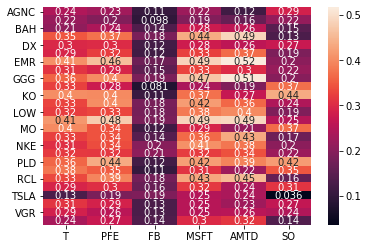

AGNC    0.259903
ARR     0.272358
TSLA    0.284745
TWO     0.297861
DX      0.320397
BAH     0.321472
STAG    0.330850
WEN     0.332784
ENB     0.352244
K       0.354619
dtype: float64

Based on correlations, best picks would be:


,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
ARR,"ARMOUR Residential REIT, Inc.",Real Estate,REIT—Mortgage,HOLD,83.52,0.190264,-0.034201,0.196056,-0.063524,0.222064
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,HOLD,82.77,0.060804,0.394617,0.508353,0.291787,0.498924
STAG,"STAG Industrial, Inc.",Real Estate,REIT—Industrial,HOLD,81.07,0.254068,0.151899,0.192907,0.148499,0.215807
TWO,Two Harbors Investment Corp.,Real Estate,REIT—Mortgage,HOLD,80.40,0.251358,0.094120,0.148531,0.089143,0.180255
AGNC,AGNC Investment Corp.,Real Estate,REIT—Mortgage,HOLD,79.71,0.146751,0.106007,0.149837,0.103751,0.182696
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,HOLD,79.59,0.133266,0.202609,0.232890,0.191056,0.253938
DX,"Dynex Capital, Inc.",Real Estate,REIT—Mortgage,HOLD,64.33,0.255192,0.009768,0.158353,-0.000796,0.189585


In [56]:
sns.heatmap(log_ret.corr(method='pearson').loc[selection.index, portfolio], annot=True)
plt.show()

bestPick = pd.Series(data=np.zeros(len(selection.index)), index=selection.index)

for b in bestPick.index:
    pear = pearsonr(log_ret['Portfolio'], log_ret[b])
    spear = spearmanr(log_ret['Portfolio'], log_ret[b])

    pSum = pear[1]+spear[1]
    if np.logical_and(pear[1]<0.05, spear[1]<0.05):
        bestPick.loc[b] = pear[0]*pear[1]/pSum + spear[0]*spear[1]/pSum
    elif pear[1]<0.05:
        bestPick.loc[b] = pear[0]
    elif spear[1]<0.05:
        bestPick.loc[b] = spear[0]

bestPick = bestPick.dropna()
bestCOR = bestPick[bestPick < bestPick.quantile(0.25)].sort_values().index.to_list()

print(bestPick.sort_values().head(10))
print('\nBased on correlations, best picks would be:')#\n{}'.format(bestCOR))

profiles.loc[bestCOR].sort_values(by='Profit Prob.', ascending=False)

In [57]:
n = 100
simRet = pd.DataFrame(columns=sel, index=list(range(n)))
simRisk = pd.DataFrame(columns=sel, index=list(range(n)))

for asset in sel:
    simRet[asset] = 0.0
    simRisk[asset] = 0.0

    for i in range(n):
        mu = ret[asset].mean()
        sigma = ret[asset].std()
        
        simulations = (np.ones(n*365) * mu -(sigma**2)/2) + np.random.standard_normal(n*365) * sigma
        
        simRet.loc[i, asset] = np.mean(simulations) * 365
        simRisk.loc[i, asset] = np.std(simulations) * np.sqrt(365)


bestRisk = simRisk.mode().median().sort_values()
bestRisk = bestRisk[bestRisk < bestRisk.quantile(0.25)]

bestReturns = simRet.mode().median()
bestReturns = bestReturns[bestReturns>bestReturns.quantile(0.75)]

bestSharpe = bestReturns/bestRisk
bestSharpe = bestSharpe[bestSharpe > bestSharpe.quantile(0.75)].sort_values(ascending=False)

if 'Portfolio' in bestSharpe.index: bestSharpe = bestSharpe.drop('Portfolio')
if 'Portfolio' in bestRisk.index: bestRisk = bestRisk.drop('Portfolio')
if 'Portfolio' in bestReturns.index: bestReturns = bestReturns.drop('Portfolio')

bestReturns.sort_values(ascending=False)

TSLA    0.365819
BAH     0.250146
LMT     0.241572
WEN     0.240383
RCL     0.213183
NKE     0.212340
GGG     0.194288
dtype: float64

In [58]:
invetable = []

if len(bestSH)>=1:
    #print('\nBased on Return/Risk ratio, best picks would be:')
    for p in bestSH:
        #print(p)
        invetable.append(p)

if len(lowestRisk)>=1:
    #print('\nBased on Risk, best picks would be:')
    for p in lowestRisk:
        #print(p)
        invetable.append(p)

if len(bestCOR)>=1:
    #print('\nBased on correlations, best picks would be:')
    for p in bestCOR:
        #print(p)
        invetable.append(p)

if len(underVal)>=1:
    #print('\nBased on historical prices these stocks seam undervalued:')
    for p in underVal:
        #print(p)
        invetable.append(p)

try:
    if len(bestSharpe.index)>=1:
        #print('\nBased on simulated Return/Risk ratio, best picks would be:')        
        for p in bestSharpe.index.to_list():
            #print(p)
            invetable.append(p)

    if len(bestRisk.index):
        #print('\nBased on simulated Risk, best picks would be:')        
        for p in bestRisk.index.to_list():
            #print(p)
            invetable.append(p)

    if len(bestReturns.index)>=1:
        #print('\nBased on simulated Return, best picks would be:')        
        for p in bestReturns.index.to_list():
            #print(p)
            invetable.append(p)
except:
    print('\nNo simulations were made.')
    
invDF = pd.DataFrame(invetable).groupby(0)[0].count()
print('\nMost frequently picked assets:')
profiles.loc[invDF.sort_values(ascending=False)[invDF==invDF.max()].index]


Most frequently picked assets:


,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
0,,,,,,,,,,
TWO,Two Harbors Investment Corp.,Real Estate,REIT—Mortgage,HOLD,80.40,0.251358,0.094120,0.148531,0.089143,0.180255
LMT,Lockheed Martin Corporation,Industrials,Aerospace & Defense,HOLD,80.96,0.313079,0.196199,0.159947,0.202070,0.177269
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,HOLD,79.59,0.133266,0.202609,0.232890,0.191056,0.253938
AGNC,AGNC Investment Corp.,Real Estate,REIT—Mortgage,HOLD,79.71,0.146751,0.106007,0.149837,0.103751,0.182696


In [59]:
selection[selection['Beta'] <= selection['Beta'].quantile(0.25)].sort_values(by='Profit Prob.',
                                                                             ascending=False)

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,HOLD,82.77,0.060804,0.394617,0.508353
PM,Philip Morris International Inc.,Consumer Defensive,Tobacco,HOLD,80.88,0.163904,0.114891,0.196154
AGNC,AGNC Investment Corp.,Real Estate,REIT—Mortgage,HOLD,79.71,0.146751,0.106007,0.149837
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,HOLD,79.59,0.133266,0.202609,0.232890
OKE,"ONEOK, Inc.",Energy,Oil & Gas Midstream,BUY,79.54,0.141297,0.214585,0.282680
EBF,"Ennis, Inc.",Industrials,Business Equipment & Supplies,HOLD,76.89,0.176585,0.096234,0.245527
VGR,Vector Group Ltd.,Consumer Defensive,Tobacco,HOLD,75.20,0.154700,0.163399,0.198308


In [60]:
profiles[np.logical_and(profiles['Beta'] <= profiles['Beta'].quantile(0.25), profiles['Action'] != 'SELL')].sort_values(by='Beta')

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,HOLD,82.77,0.060804,0.394617,0.508353,0.291787,0.498924
AGM,Federal Agricultural Mortgage Corporation,Financial Services,Credit Services,HOLD,74.67,0.102875,0.320423,0.403781,0.268549,0.394987
YORW,The York Water Company,Utilities,Utilities—Regulated Water,HOLD,72.09,0.125766,0.151117,0.185684,0.139812,0.255639
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,HOLD,79.59,0.133266,0.202609,0.232890,0.191056,0.253938
OKE,"ONEOK, Inc.",Energy,Oil & Gas Midstream,BUY,79.54,0.141297,0.214585,0.282680,0.190141,0.297718
PEBO,Peoples Bancorp Inc.,Financial Services,Banks—Regional,HOLD,74.19,0.145338,0.180632,0.281412,0.166954,0.338243
AGNC,AGNC Investment Corp.,Real Estate,REIT—Mortgage,HOLD,79.71,0.146751,0.106007,0.149837,0.103751,0.182696
VGR,Vector Group Ltd.,Consumer Defensive,Tobacco,HOLD,75.20,0.154700,0.163399,0.198308,0.158970,0.218484
AAPL,Apple Inc.,Technology,Consumer Electronics,BUY,81.17,0.157448,0.254592,0.247212,0.242454,0.257631
NTAP,"NetApp, Inc.",Technology,Computer Hardware,HOLD,77.55,0.161660,0.126853,0.323430,0.075985,0.324702


In [61]:
profiles[profiles['Action'] == 'BUY'].sort_values(by='Profit Prob.',
                                                  ascending=False)

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
AAPL,Apple Inc.,Technology,Consumer Electronics,BUY,81.17,0.157448,0.254592,0.247212,0.242454,0.257631
OKE,"ONEOK, Inc.",Energy,Oil & Gas Midstream,BUY,79.54,0.141297,0.214585,0.282680,0.190141,0.297718
JPM,JPMorgan Chase & Co.,Financial Services,Banks—Diversified,BUY,78.03,0.288370,0.157853,0.220737,0.139305,0.250331


In [62]:
profiles[profiles['Profit Prob.'] > 85.0].sort_values(by='Profit Prob.', ascending=False)

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,LOGRET,LOGSTD
AMTD,TD Ameritrade Holding Corporation,Financial Services,Capital Markets,SELL,100.00,0.267799,0.153246,0.282439,0.113135,0.294879
NFLX,"Netflix, Inc.",Communication Services,Entertainment,SELL,93.38,0.054961,0.489363,0.550316,0.375737,0.517676
RF,Regions Financial Corporation,Financial Services,Banks—Regional,SELL,93.04,0.202550,0.153897,0.301972,0.125086,0.339036
KEY,KeyCorp,Financial Services,Banks—Regional,SELL,90.61,0.248374,0.150651,0.248027,0.138694,0.292486
PII,Polaris Inc.,Consumer Cyclical,Recreational Vehicles,SELL,90.58,0.143531,0.208540,0.302690,0.170509,0.331057
WLK,Westlake Chemical Corporation,Basic Materials,Specialty Chemicals,SELL,90.41,0.147431,0.244551,0.365183,0.182851,0.371777
KMB,Kimberly-Clark Corporation,Consumer Defensive,Household & Personal Products,SELL,90.18,0.269443,0.119900,0.138625,0.115336,0.164635
CVS,CVS Health Corporation,Healthcare,Healthcare Plans,SELL,89.76,0.233496,0.112064,0.202880,0.100613,0.218866
CVX,Chevron Corporation,Energy,Oil & Gas Integrated,SELL,89.24,0.323650,0.092573,0.186175,0.079313,0.210411
CMA,Comerica Incorporated,Financial Services,Banks—Regional,HOLD,88.56,0.251155,0.119726,0.259594,0.098097,0.281377
